# Goal of User Engagement Analysis:
The objective of User Engagement Analysis is to track how users interact with different applications on the network by analyzing their session frequency, session duration, and data usage (both download and upload traffic). The goal is to categorize users based on their engagement levels and understand the overall user activity on the network.

## Key Engagement Metrics:
1. **Session Frequency**: Number of sessions initiated by a user.
2. **Session Duration**: Total time spent by a user in all sessions.
3. **Total Traffic**: Data downloaded and uploaded by a user.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath('../scripts'))
from db_connection import load_data_from_postgres
sys.path.append(os.path.abspath('../src'))

from utils import visualize_missing_values, replace_missing_values     

from engagement_analysis_utils import normalize_data, apply_kmeans, plot_elbow_method,\
    visualize_clusters_with_centroids, top_10_users_per_application, plot_top_3_applications

from user_analysis_utils import aggregate_user_data

### Load Only Relevant Columns

In [2]:
# Define your SQL query
query = """
SELECT 
    "Bearer Id",
    "MSISDN/Number",
    "Dur. (ms)",
    "Total DL (Bytes)",
    "Total UL (Bytes)",
    "Social Media DL (Bytes)",
    "Social Media UL (Bytes)",
    "Google DL (Bytes)",
    "Google UL (Bytes)",
    "Email DL (Bytes)",
    "Email UL (Bytes)",
    "Youtube DL (Bytes)",
    "Youtube UL (Bytes)",
    "Netflix DL (Bytes)",
    "Netflix UL (Bytes)",
    "Gaming DL (Bytes)",
    "Gaming UL (Bytes)",
    "Other DL (Bytes)",
    "Other UL (Bytes)"
FROM xdr_data;
"""

# Load data from PostgreSQL
df = load_data_from_postgres(query)

if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

/home/seife/Desktop/Kifiya_AIM/Telecom-User-Analytics/scripts/db_connection.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [3]:
df.head()

,Bearer Id,MSISDN/Number,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes)
0,1.311448e+19,3.366496e+10,1823652.0,308879636.0,36749741.0,1545765.0,24420.0,1634479.0,1271433.0,3563542.0,137762.0,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0
1,1.311448e+19,3.368185e+10,1365104.0,653384965.0,53800391.0,1926113.0,7165.0,3493924.0,920172.0,629046.0,308339.0,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0
2,1.311448e+19,3.376063e+10,1361762.0,279807335.0,27883638.0,1684053.0,42224.0,8535055.0,1694064.0,2690151.0,672973.0,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0
3,1.311448e+19,3.375034e+10,1321509.0,846028530.0,43324218.0,644121.0,13372.0,9023734.0,2788027.0,1439754.0,631229.0,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0
4,1.311448e+19,3.369980e+10,1089009.0,569138589.0,38542814.0,862600.0,50188.0,6248284.0,1500559.0,1936496.0,173853.0,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0


## Data Preparation

### Visualize missing values

<Axes: >

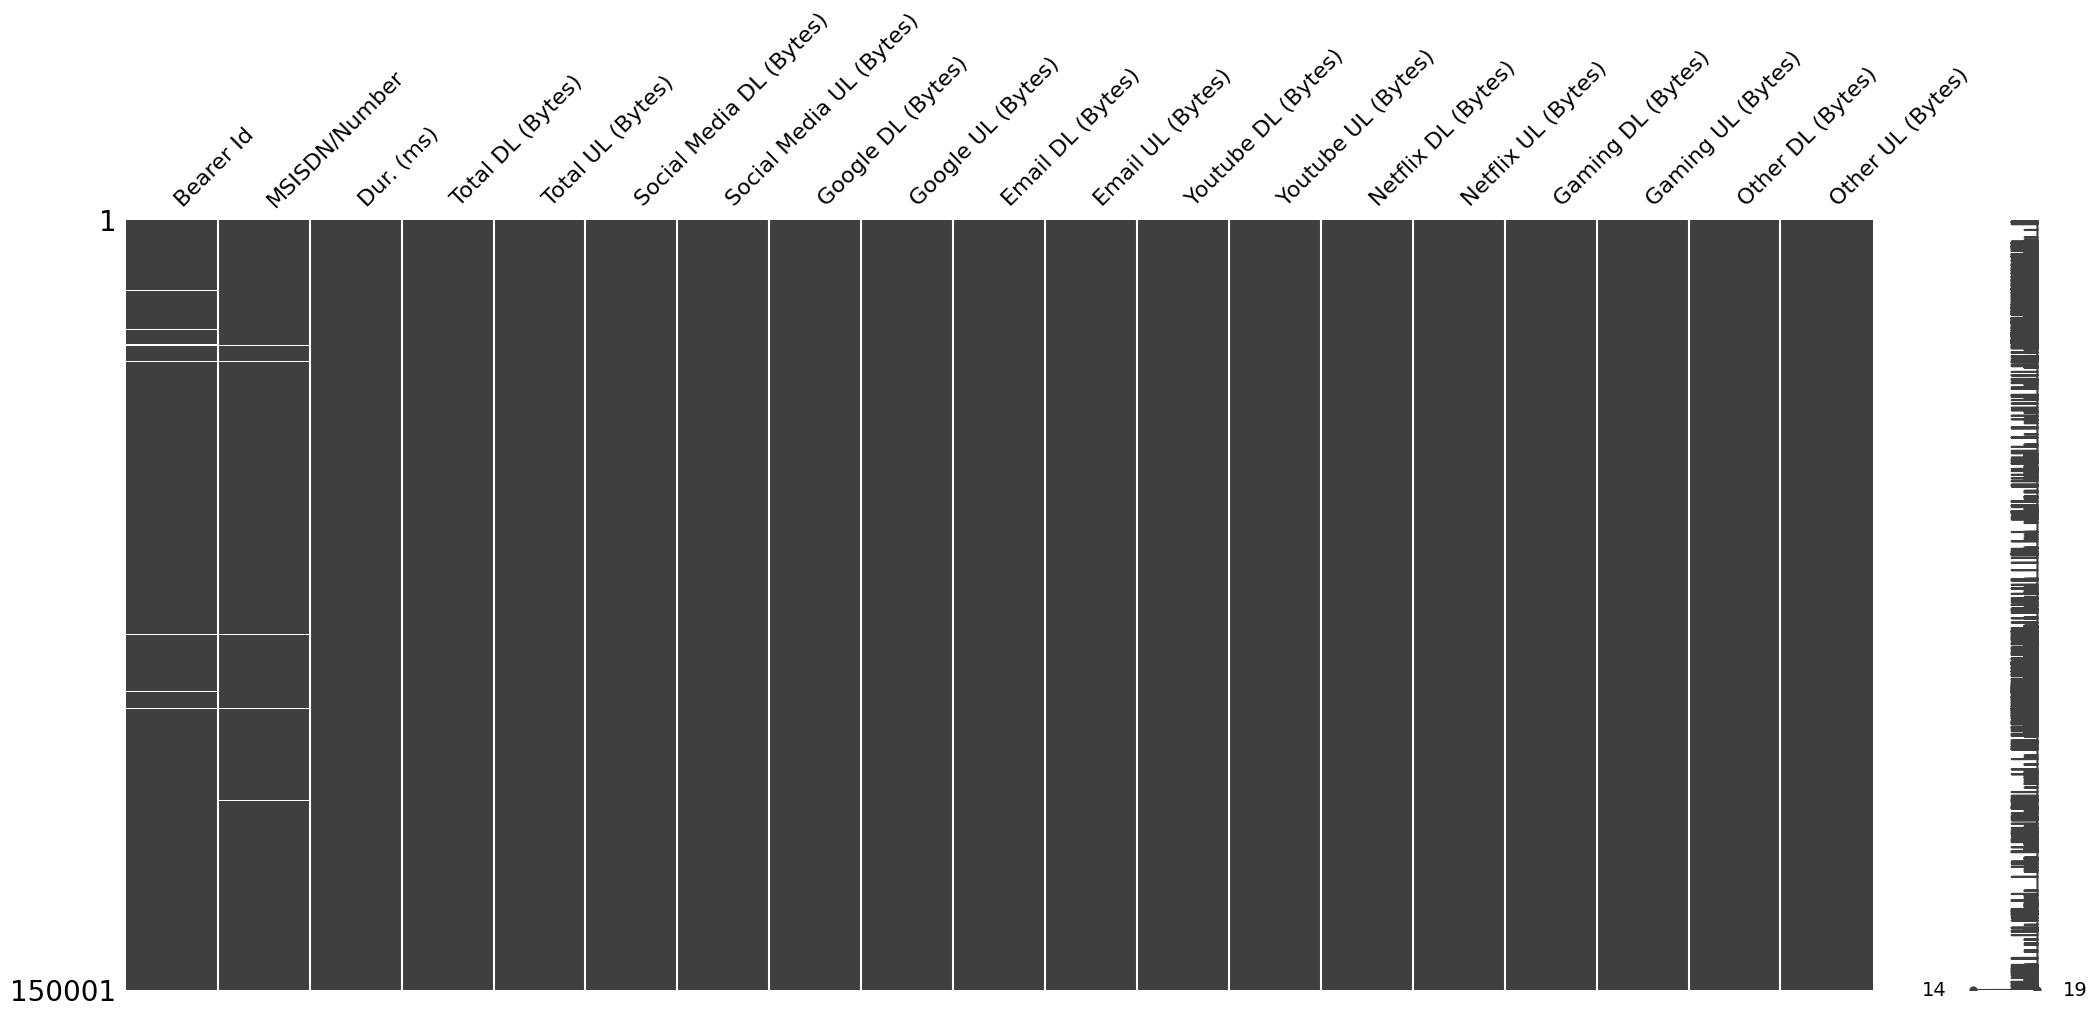

In [4]:
# Visualize missing values
visualize_missing_values(df)

### Replace missing values by median

Replacing 5 Numeric columns by median value ...
Replacing Completed!!



<Axes: >

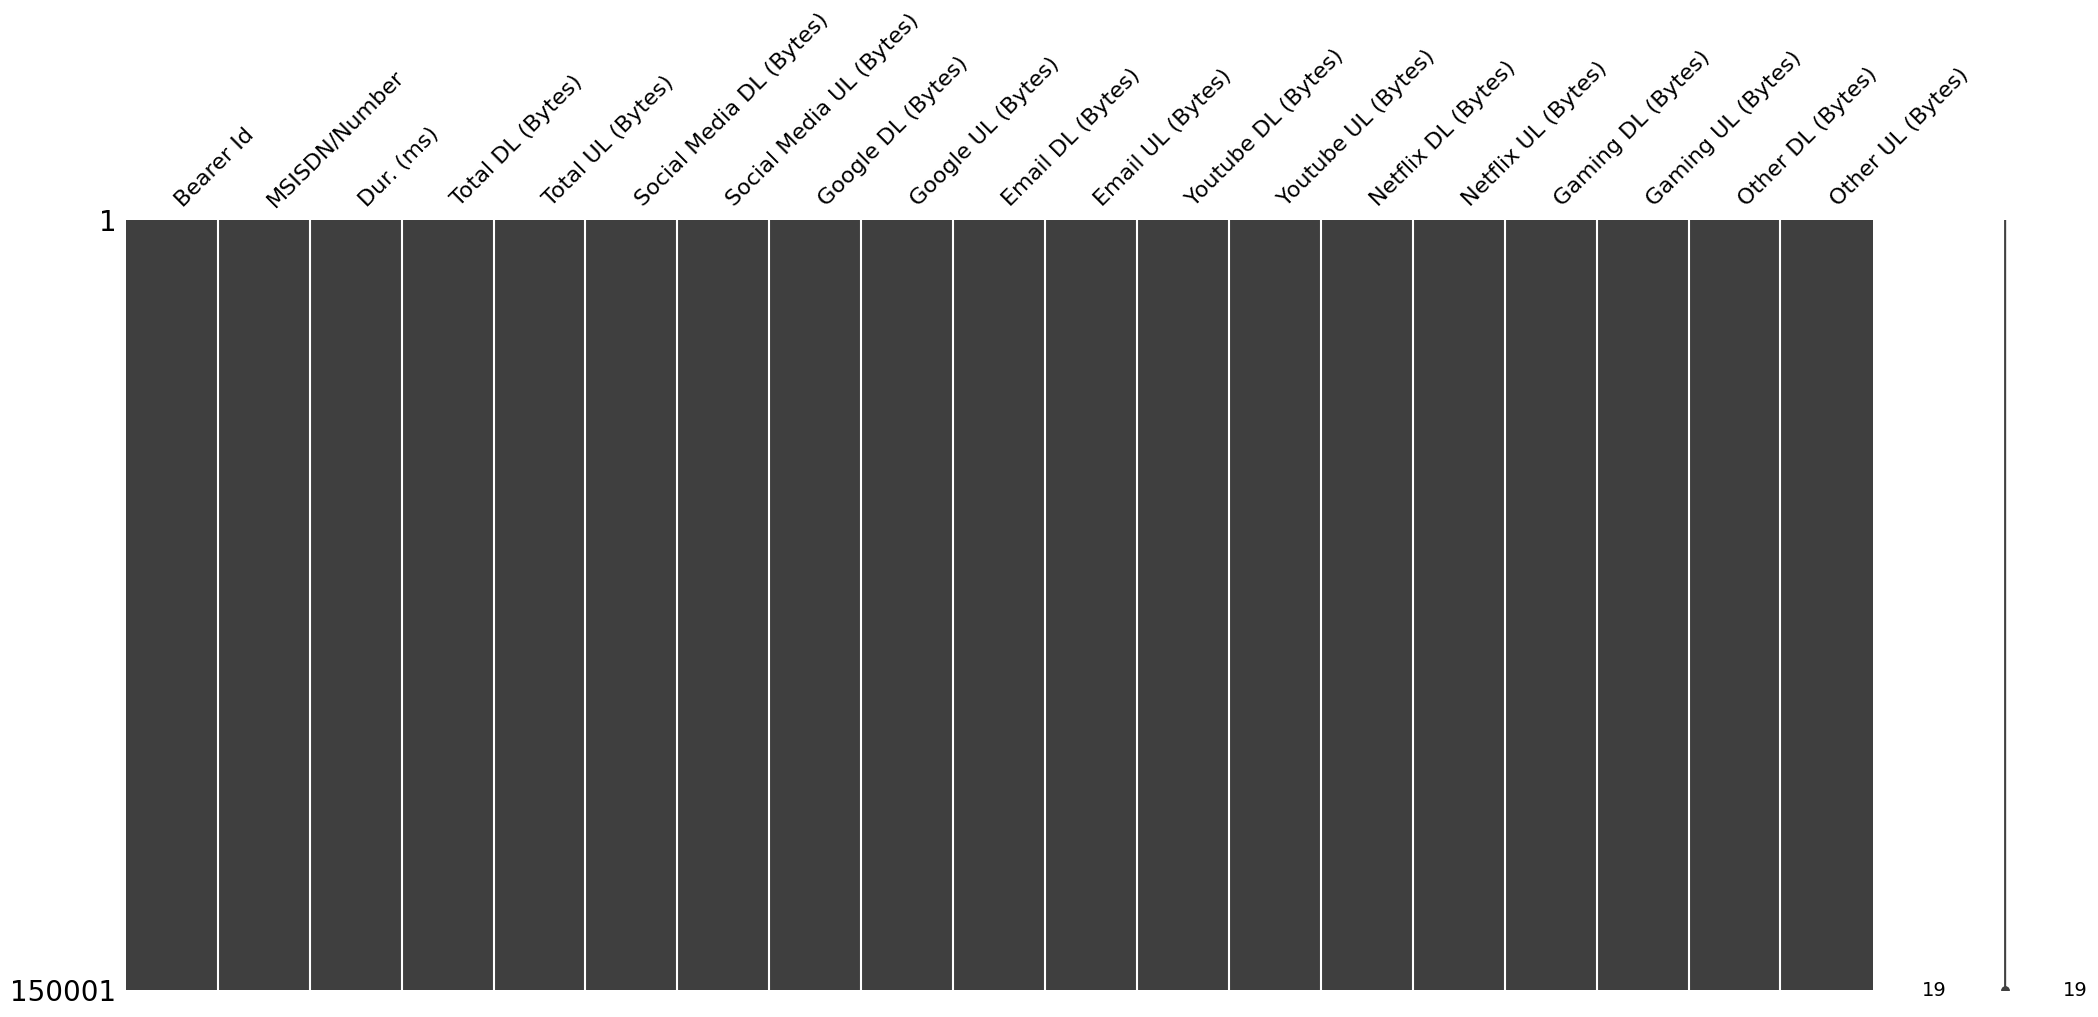

In [5]:
# Replace missing values by median
replace_missing_values(df)

<Axes: >

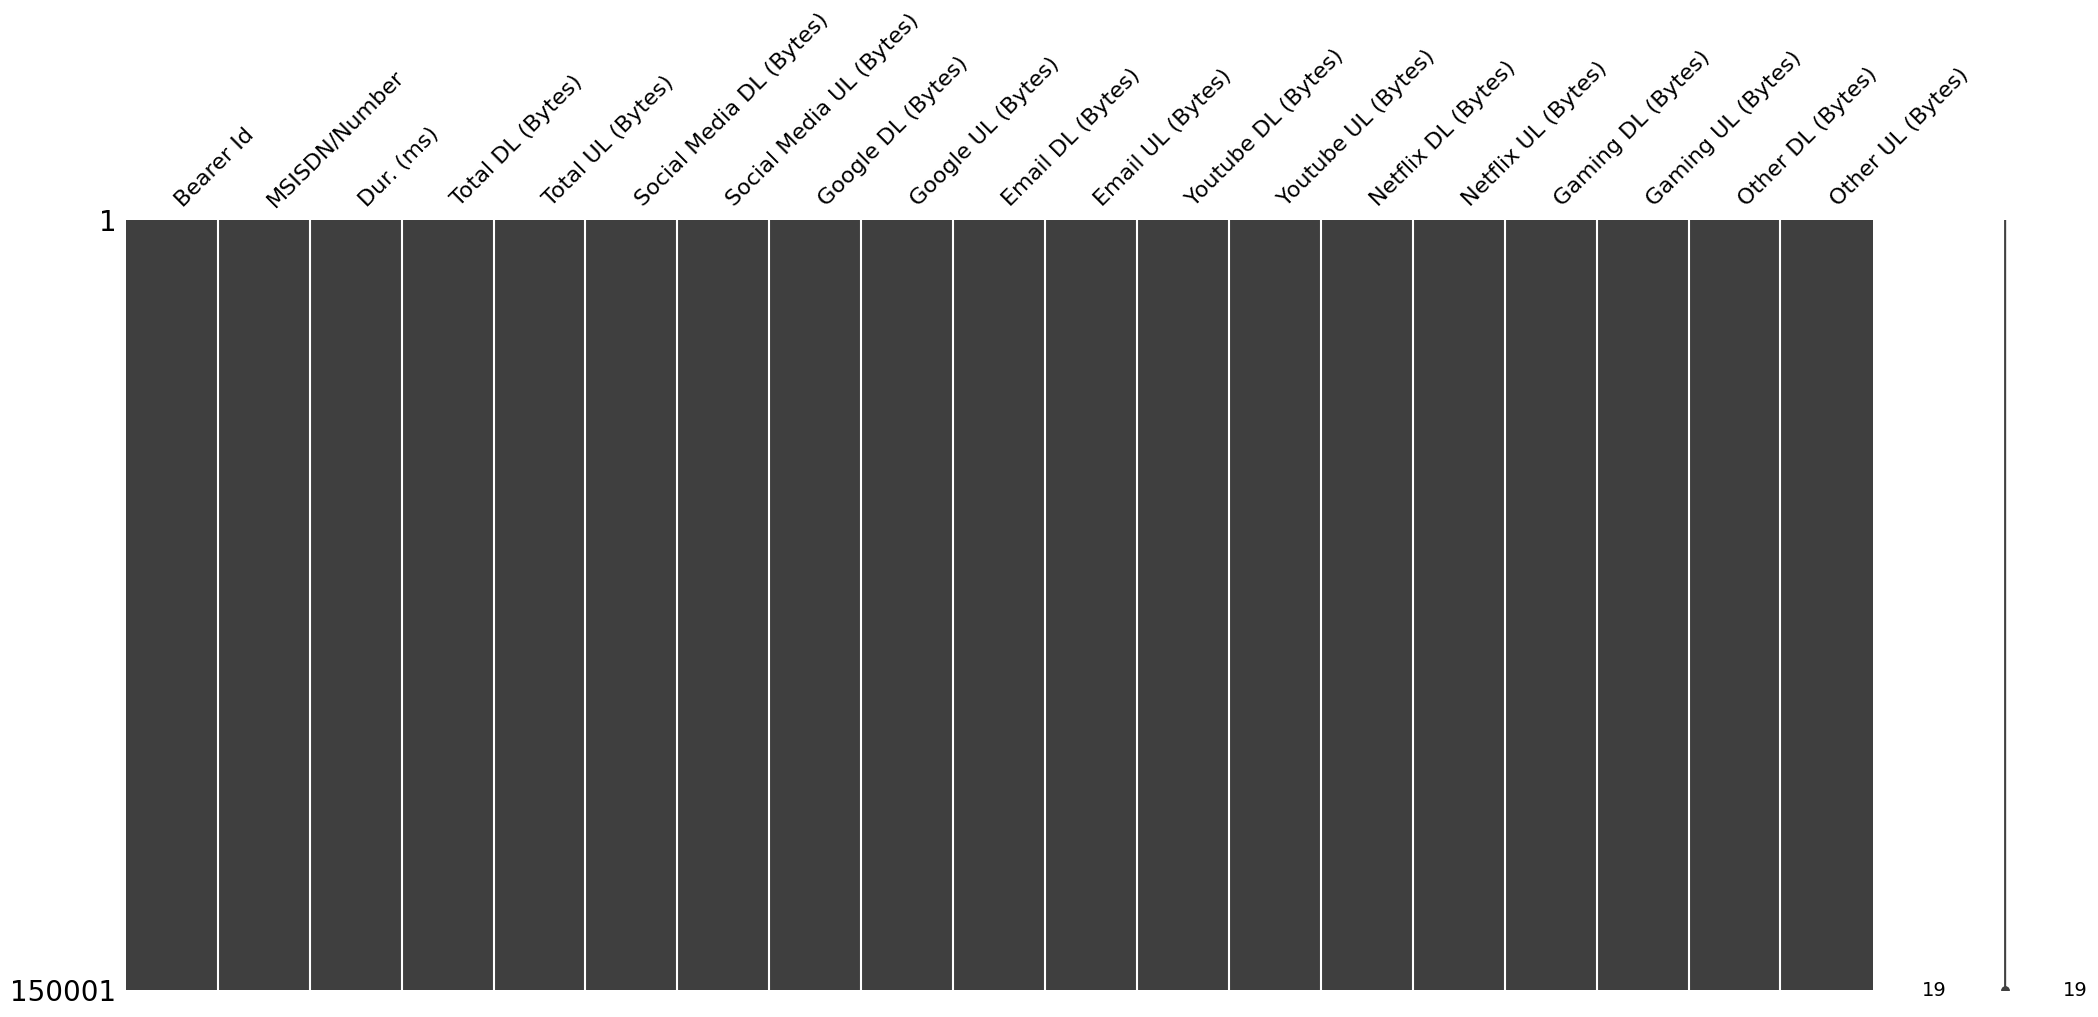

In [6]:
# Visualize missing values
visualize_missing_values(df)

### Check for duplicate

In [7]:
#rows
duplicated_rows = df[df.duplicated()]
if len(duplicated_rows) > 0:
    print(f"Duplicate rows found: {len(duplicated_rows)}")
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [8]:
# columns
duplicated_columns = df.columns[df.columns.duplicated()]
if len(duplicated_columns) > 0:
    print(f"Duplicate columns found: {', '.join(duplicated_columns)}")
else:
    print("No duplicate columns found.")

No duplicate columns found.


## Aggregate Engagement Metrics:

In [9]:
# Displaying the aggregated data
aggregated_data = aggregate_user_data(df)
aggregated_data.head(10)

,MSISDN/Number,session_count,total_duration_ms,total_download,total_upload,Social Media_total_data,Google_total_data,Email_total_data,Youtube_total_data,Netflix_total_data,Gaming_total_data,Other_total_data
0,3.360100e+10,1,116720.0,8.426375e+08,36053108.0,3.865709e+08,3.865709e+08,3.865709e+08,3.865709e+08,3.865709e+08,3.865709e+08,3.865709e+08
1,3.360100e+10,1,181230.0,1.207552e+08,36104459.0,2.817101e+08,2.817101e+08,2.817101e+08,2.817101e+08,2.817101e+08,2.817101e+08,2.817101e+08
2,3.360100e+10,1,134969.0,5.566597e+08,39306820.0,5.016937e+08,5.016937e+08,5.016937e+08,5.016937e+08,5.016937e+08,5.016937e+08,5.016937e+08
3,3.360101e+10,1,49878.0,4.019932e+08,20327526.0,3.527970e+07,3.527970e+07,3.527970e+07,3.527970e+07,3.527970e+07,3.527970e+07,3.527970e+07
4,3.360101e+10,2,37104.0,1.363130e+09,94280527.0,8.048045e+08,8.048045e+08,8.048045e+08,8.048045e+08,8.048045e+08,8.048045e+08,8.048045e+08
5,3.360101e+10,2,253983.0,5.552080e+08,60009249.0,4.923728e+08,4.923728e+08,4.923728e+08,4.923728e+08,4.923728e+08,4.923728e+08,4.923728e+08
6,3.360101e+10,2,128360.0,5.530412e+08,101681858.0,2.248887e+08,2.248887e+08,2.248887e+08,2.248887e+08,2.248887e+08,2.248887e+08,2.248887e+08
7,3.360101e+10,1,86399.0,2.940851e+08,38575279.0,1.782015e+08,1.782015e+08,1.782015e+08,1.782015e+08,1.782015e+08,1.782015e+08,1.782015e+08
8,3.360101e+10,2,495702.0,8.965602e+08,93572016.0,1.041883e+09,1.041883e+09,1.041883e+09,1.041883e+09,1.041883e+09,1.041883e+09,1.041883e+09
9,3.360102e+10,1,124854.0,6.853728e+08,47091008.0,1.383392e+08,1.383392e+08,1.383392e+08,1.383392e+08,1.383392e+08,1.383392e+08,1.383392e+08


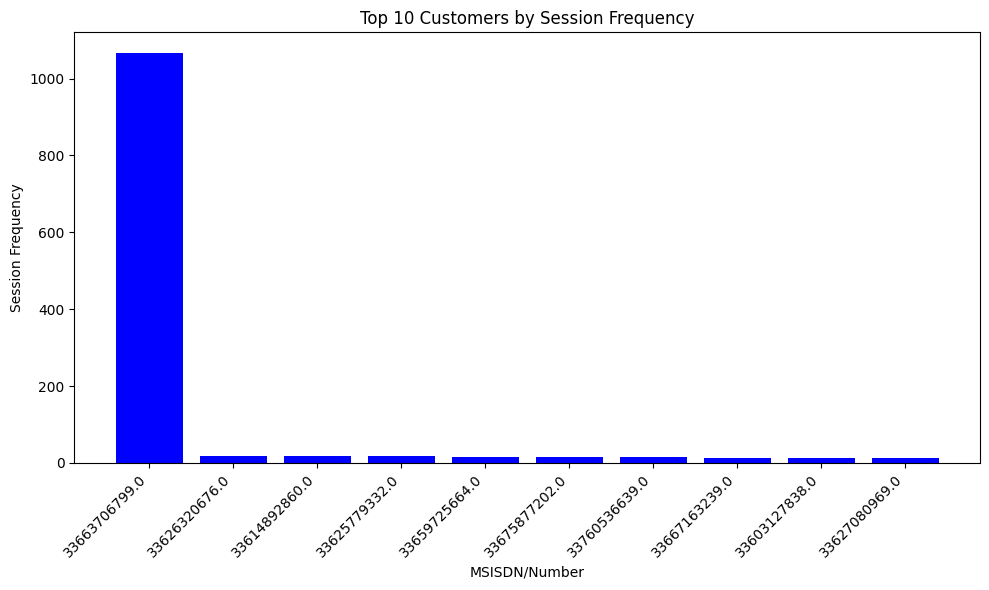

In [10]:
top_session_count = aggregated_data[['MSISDN/Number', 'session_count']].sort_values(by='session_count', ascending=False).head(10)

# Create a bar plot for the top 10 customers
plt.figure(figsize=(10, 6))
plt.bar(top_session_count['MSISDN/Number'].astype(str), top_session_count['session_count'], color='blue')

# Add title and labels
plt.title("Top 10 Customers by Session Frequency")
plt.xlabel("MSISDN/Number")
plt.ylabel("Session Frequency")

# Rotate x-axis labels for better readability

plt.xticks(ha='right', rotation=45)

# Show plot
plt.tight_layout()
plt.show()

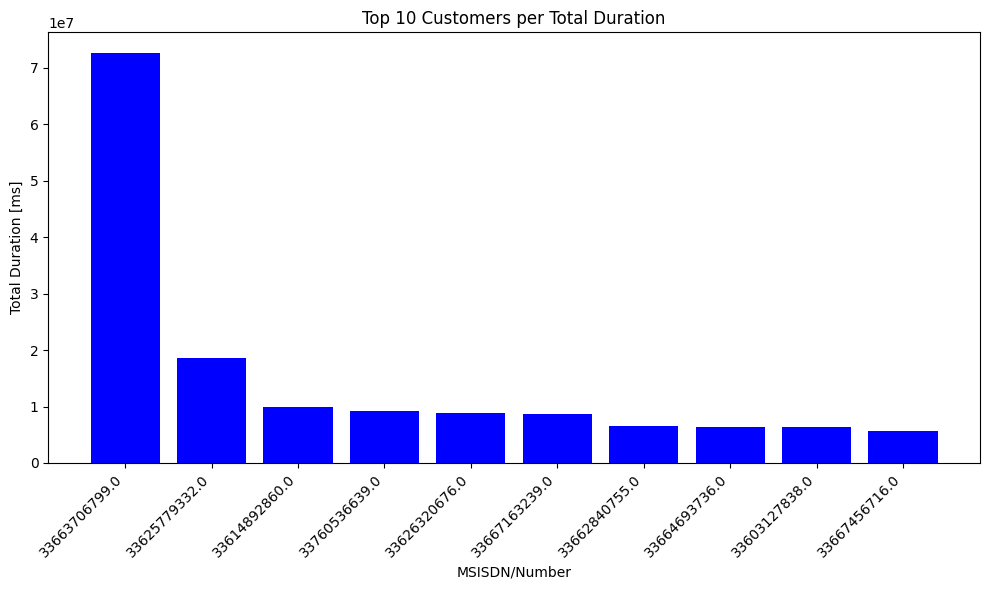

In [11]:
top_total_duration_ms = aggregated_data[['MSISDN/Number', 'total_duration_ms']].sort_values(by='total_duration_ms', ascending=False).head(10)

# Create a bar plot for the top 10 customers
plt.figure(figsize=(10, 6))
plt.bar(top_total_duration_ms['MSISDN/Number'].astype(str), top_total_duration_ms['total_duration_ms'], color='blue')

# Add title and labels
plt.title("Top 10 Customers per Total Duration")
plt.xlabel("MSISDN/Number")
plt.ylabel("Total Duration [ms]")

# Rotate x-axis labels for better readability
plt.xticks(ha='right', rotation=45)

# Show plot
plt.tight_layout()
plt.show()

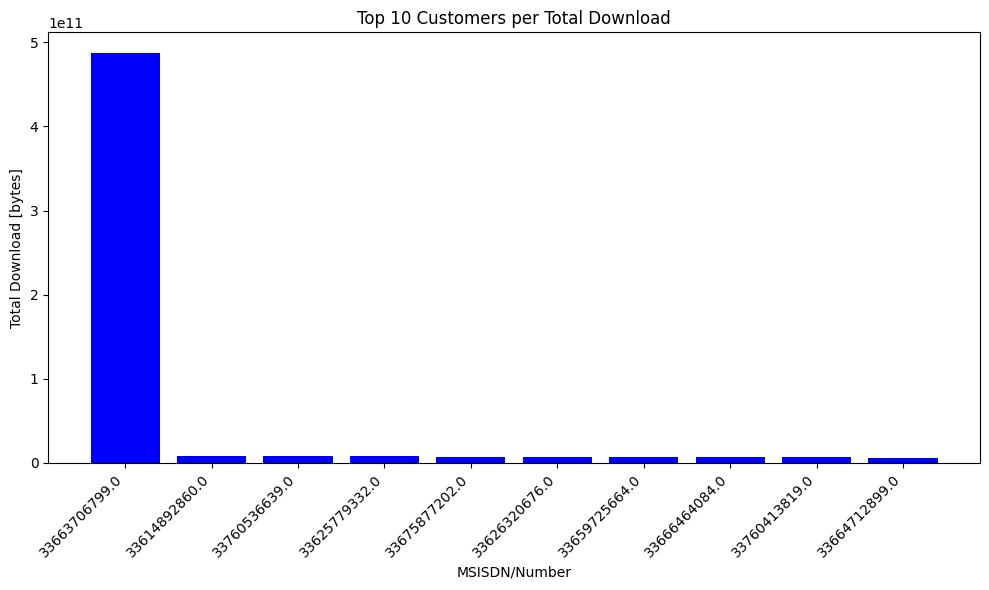

In [12]:
top_total_download = aggregated_data[['MSISDN/Number', 'total_download']].sort_values(by='total_download', ascending=False).head(10)

# Create a bar plot for the top 10 customers
plt.figure(figsize=(10, 6))
plt.bar(top_total_download['MSISDN/Number'].astype(str), top_total_download['total_download'], color='blue')

# Add title and labels
plt.title("Top 10 Customers per Total Download")
plt.xlabel("MSISDN/Number")
plt.ylabel("Total Download [bytes]")

# Rotate x-axis labels for better readability
plt.xticks(ha='right', rotation=45)

# Show plot
plt.tight_layout()
plt.show()

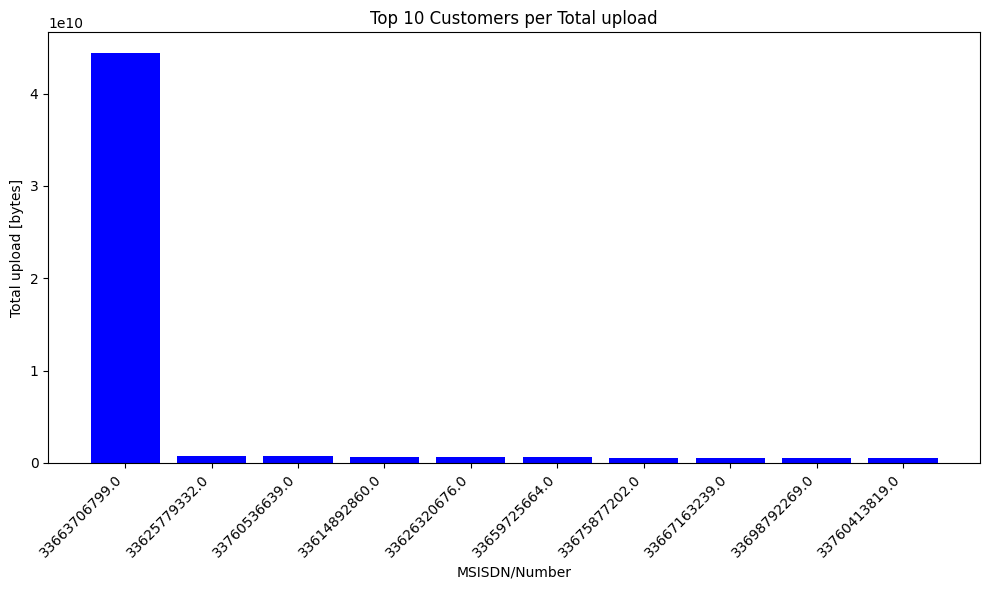

In [13]:
top_total_upload = aggregated_data[['MSISDN/Number', 'total_upload']].sort_values(by='total_upload', ascending=False).head(10)

# Create a bar plot for the top 10 customers
plt.figure(figsize=(10, 6))
plt.bar(top_total_upload['MSISDN/Number'].astype(str), top_total_upload['total_upload'], color='blue')

# Add title and labels
plt.title("Top 10 Customers per Total upload")
plt.xlabel("MSISDN/Number")
plt.ylabel("Total upload [bytes]")

# Rotate x-axis labels for better readability
plt.xticks(ha='right', rotation=45)

# Show plot
plt.tight_layout()
plt.show()

## Clustering Users by Engagement

Since metrics like session count, session duration, and total data usage are on different scales, we need to normalize them before applying clustering.

After normalizing the data frame, I can cluster the users based on their engagement metrics. I will use **K-means clustering with k=3** to classify users into different engagement levels (low, medium, high).

In [14]:
# Normalize data
normalized_user_data = normalize_data(aggregated_data)
clustered_data, kmeans_model = apply_kmeans(normalized_user_data, 'total_duration_ms', 'session_count', num_clusters=3)

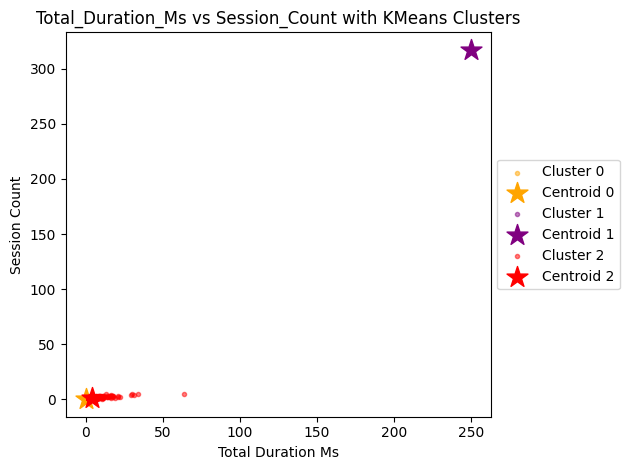

In [15]:
# Visualize clusters
visualize_clusters_with_centroids(clustered_data, kmeans_model, 'total_duration_ms', 'session_count')

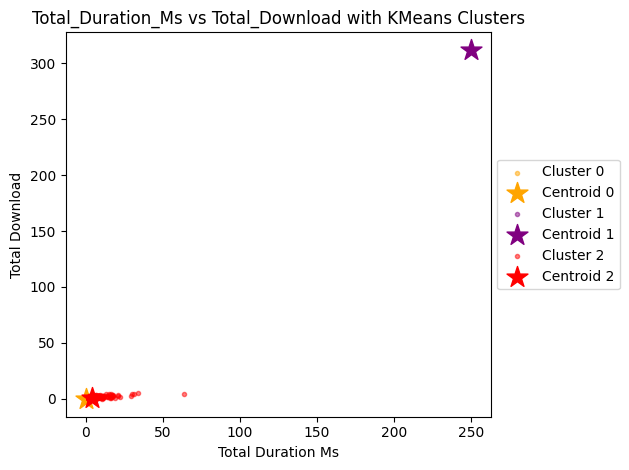

In [16]:
# Visualize clusters
clustered_data, kmeans_model = apply_kmeans(normalized_user_data, 'total_duration_ms', 'total_download', num_clusters=3)
visualize_clusters_with_centroids(clustered_data, kmeans_model, 'total_duration_ms', 'total_download')

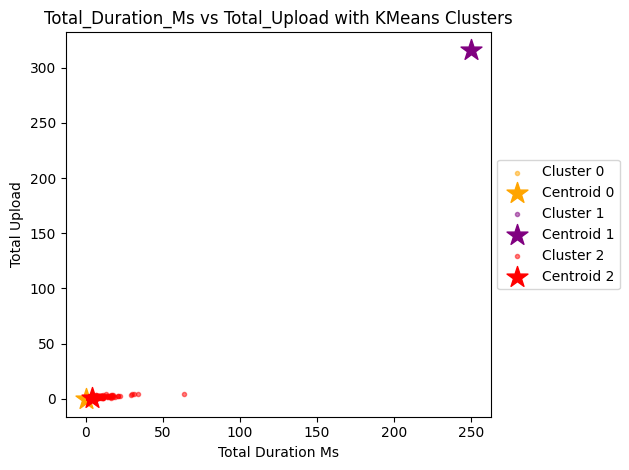

In [17]:
# Visualize clusters
clustered_data, kmeans_model = apply_kmeans(normalized_user_data, 'total_duration_ms', 'total_upload', num_clusters=3)
visualize_clusters_with_centroids(clustered_data, kmeans_model, 'total_duration_ms', 'total_upload')

### Deriving Top 10 Most Engaged Users Per Application

In [18]:
top_10_users = top_10_users_per_application(normalized_user_data)

top_10_users

{'Social Media_total_data':        MSISDN/Number  Social Media_total_data
 53644   3.366371e+10             4.516521e+11
 13526   3.362632e+10             8.167878e+09
 6437    3.361489e+10             7.639264e+09
 76363   3.367588e+10             6.798515e+09
 13180   3.362578e+10             6.354583e+09
 666     3.360313e+10             6.326671e+09
 37052   3.365973e+10             6.317415e+09
 13936   3.362695e+10             5.305448e+09
 13994   3.362708e+10             5.117791e+09
 94654   3.376127e+10             5.077779e+09,
 'Google_total_data':        MSISDN/Number  Google_total_data
 53644   3.366371e+10       4.516521e+11
 13526   3.362632e+10       8.167878e+09
 6437    3.361489e+10       7.639264e+09
 76363   3.367588e+10       6.798515e+09
 13180   3.362578e+10       6.354583e+09
 666     3.360313e+10       6.326671e+09
 37052   3.365973e+10       6.317415e+09
 13936   3.362695e+10       5.305448e+09
 13994   3.362708e+10       5.117791e+09
 94654   3.376127e+10   

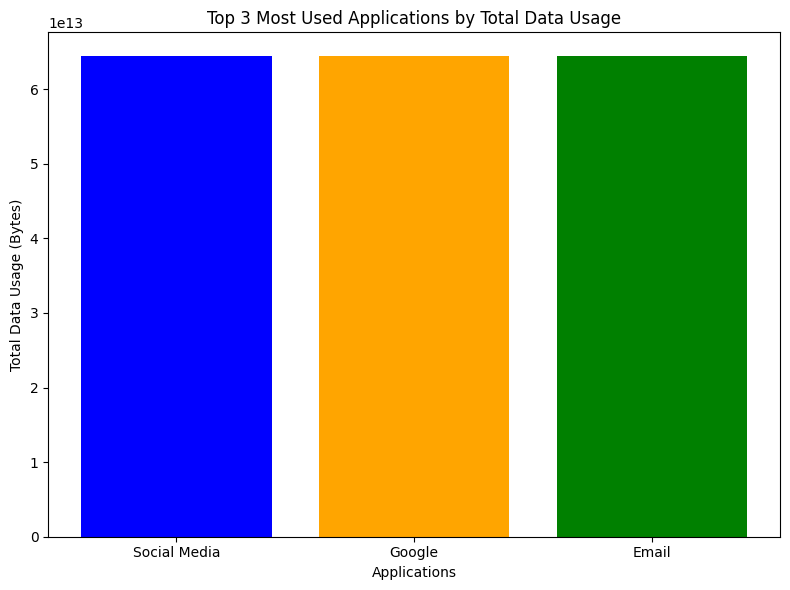

In [19]:
# Plot the top 3 most used applications
plot_top_3_applications(normalized_user_data)

### **K-means clustering with Elbow Method**

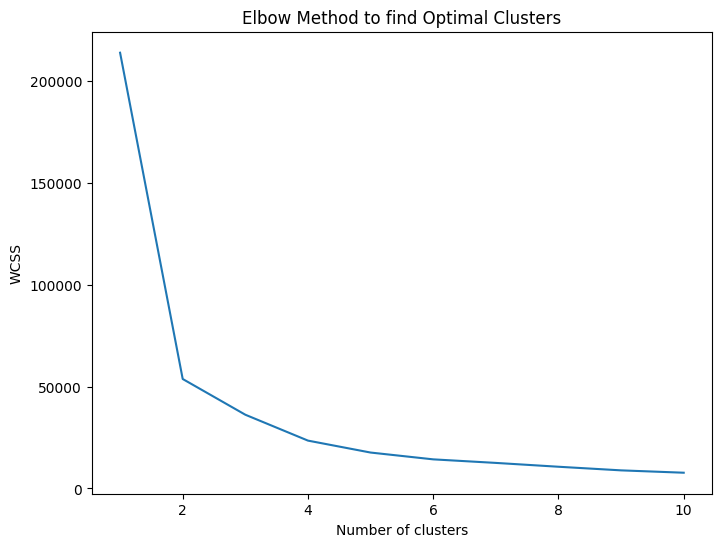

In [21]:
# Plot the elbow method to determine the best number of clusters
plot_elbow_method(normalized_user_data, 'total_duration_ms', 'total_download')

The number of clusters is where the elbow bends, hence the elbow method indicates our data has $2$ clusters. Let's plot the data.

In [30]:
# Apply KMeans with a chosen number of clusters (e.g., 3 based on elbow method)
num_clusters = 2

## Analyze and Visualize the Clusters

Once users are classified into clusters, I can analyze the distribution of users and visualize the engagement levels.

In [31]:
clustered_data, kmeans_model = apply_kmeans(normalized_user_data, 'total_duration_ms', 'total_download', num_clusters)

# Analyze the distribution of clusters for total duration and total download
centers = kmeans_model.cluster_centers_
error = kmeans_model.inertia_
lables = set(kmeans_model.labels_)

print('Centers : ')
print(centers)
print()
print('Cost : ',error)
print()

Centers : 
[[-2.34224746e-03 -2.92042642e-03]
 [ 2.50280852e+02  3.12062165e+02]]

Cost :  53687.20261875523



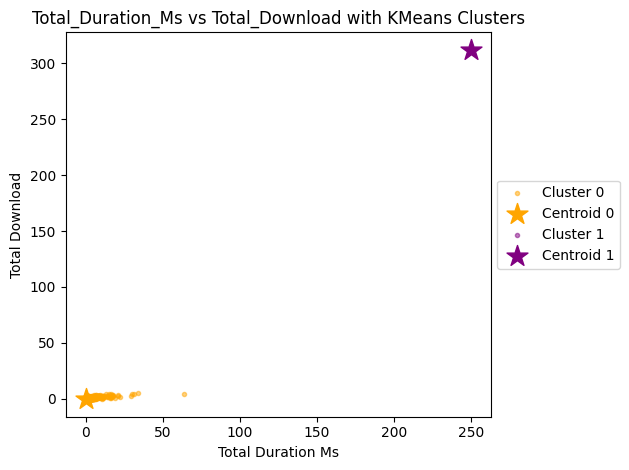

In [32]:
# Visualize clusters
visualize_clusters_with_centroids(clustered_data, kmeans_model, 'total_duration_ms', 'total_download')

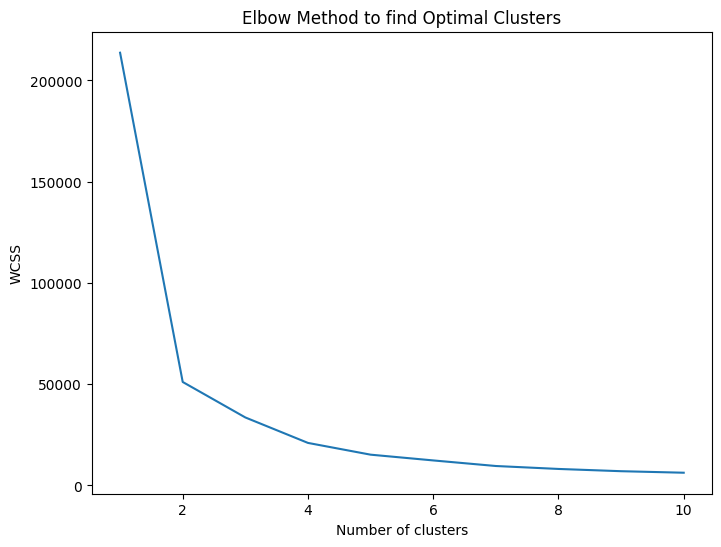

In [25]:
plot_elbow_method(normalized_user_data, 'total_duration_ms', 'total_upload')

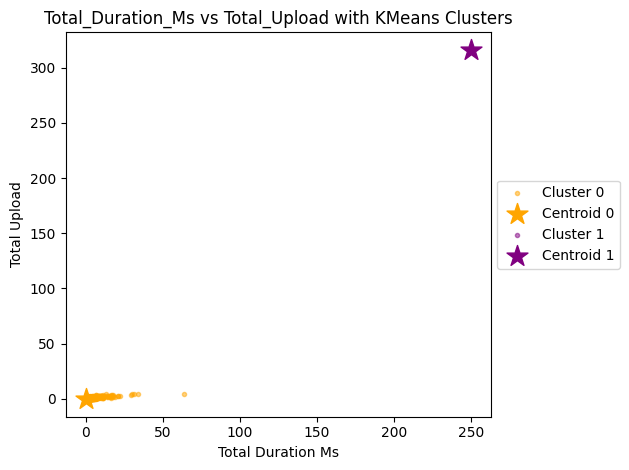

In [33]:
k=2
clustered_data, kmeans_model = apply_kmeans(normalized_user_data, 'total_duration_ms', 'total_upload', k)

visualize_clusters_with_centroids(clustered_data, kmeans_model, 'total_duration_ms', 'total_upload')

As you have seen from the above, Each cluster is represented by different colors, with the centroids marked distinctly. The clustering reveals patterns in consumer behavior:

* Cluster 0 (yellow) features customers with low duration and downloads/uploads lower bytes, suggesting that these customers spent lower time consume lower data
* Cluster 1 (purple) includes customers who spending more time and downloads/uploads much bytes, suggesting that these customers spend a significant portion of their time and data. 

For both clusterred image

And another point rather than setting **k** value manually **Elbow method** is the best approach.